In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM,FcM_like
from FDcoeffs import get_coeffs
from ao_scf import ao_RHF
from numpy.linalg import norm

In [2]:
from functools import reduce
import ctypes
import numpy
from pyscf import lib
from pyscf import gto
from pyscf.lib import logger
from pyscf.scf import _vhf
from pyscf.scf import cphf

# import _response_functions to load gen_response methods in SCF class
from pyscf.scf import _response_functions  # noqa
# import pyscf.grad.rhf to activate nuc_grad_method method
from pyscf.grad import rhf  # noqa

In [3]:
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

In [4]:
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs
from ao_scf import ao_RHF

In [54]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
mf_nn=scf.RHF(nn)
e_nn=mf_nn.scf()
mf=mf_nn
P_nn=mf_nn.make_rdm1()
S_nn=mf_nn.get_ovlp()
h1_nn=mf_nn.get_hcore()
G_nn=nn.intor('int2e', aosym='s8')
########
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]),\
           charge=1) # ON
mf_on=scf.RHF(on)
e_on=mf_on.scf()
P_on=mf_on.make_rdm1()
S_on=mf_on.get_ovlp()
h1_on=mf_on.get_hcore()
G_on=on.intor('int2e', aosym='s8')

########
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]),\
           charge=-1)# CN
mf_cn=scf.RHF(cn)
e_cn=mf_cn.scf()
P_cn=mf_cn.make_rdm1()
S_cn=mf_cn.get_ovlp()
h1_cn=mf_cn.get_hcore()
G_cn=cn.intor('int2e', aosym='s8')


converged SCF energy = -108.867942022953
converged SCF energy = -128.797709060453
converged SCF energy = -92.2174104946118


In [6]:
dS=(S_on-S_cn)/2
dh1=(h1_on-h1_cn)/2
dG=(G_on-G_cn)/2
dVnn=(8*7-7*7)/2.05
d2S=(mf_on.get_ovlp()+mf_cn.get_ovlp()-2*mf.get_ovlp())
d2h1=(mf_on.get_hcore()+mf_cn.get_hcore()-2*mf.get_hcore())
d2G=(G_on+G_cn-2*G_nn)
dG4d=(on.intor('int2e')-cn.intor('int2e'))/2

In [7]:
def S(l):
    return S_nn+dS*l+d2S*l**2/2
def h1(l):
    return h1_nn+dh1*l+d2h1*l**2/2
def eri(l):
    return G_nn+dG*l+d2G*l**2/2

In [8]:
#new definition
def S(l):
    return S_nn*(1-l)+S_on*l
def h1(l):
    return h1_nn*(1-l)+h1_on*l
def eri(l):
    return G_nn*(1-l)+G_on*l

In [84]:
def aorhf(l):
    return ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S(l),hcore=h1(l),eri=eri(l))
def E(l):
    return ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S(l),hcore=h1(l),eri=eri(l)).scf()
def P(l):
    mf=ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S(l),hcore=h1(l),eri=eri(l))
    mf.scf()
    return mf.make_rdm1()
dP_fd=(P(.05)-P(-.05))/.1
dE_fd=(E(.05)-E(-.05))/.1

converged SCF energy = -109.851667743544
converged SCF energy = -107.889646292597
converged SCF energy = -109.851667743543
converged SCF energy = -107.889646292597


In [85]:
ps=[]
es=[]
ls=np.linspace(.1,.9,5)
for i in ls:
    ps.append(P(i))
    print(np.einsum("ij,ij",S(i),ps[-1]))

converged SCF energy = -110.839252852605
14.0
converged SCF energy = -114.808775730675
14.0
converged SCF energy = -118.789834387748
14.000000000000007
converged SCF energy = -122.779687295848
13.999999999999998
converged SCF energy = -126.785557967216
14.000000000000002


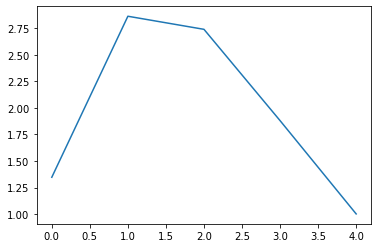

In [89]:
plt.plot([norm(P_nn-ps[x])for x in range(5)])

converged SCF energy = -106.918713211598
converged SCF energy = -109.605319586464
converged SCF energy = -112.325331264259
converged SCF energy = -115.057377911261
converged SCF energy = -117.793908855166
converged SCF energy = -120.533991238139
converged SCF energy = -123.279353884185
converged SCF energy = -126.032787363335
converged SCF energy = -128.797709060448


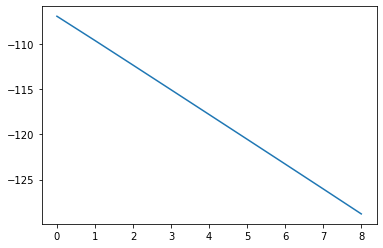

In [90]:
plt.plot([E(l) for l in np.linspace(-.1,1,9)])

In [91]:
dE_fd=(E(.05)-E(-.05))/.1

converged SCF energy = -109.851667743544
converged SCF energy = -107.889646292597


In [92]:
e_nn+dE_fd,e_on

(-128.4881565324188, -128.79770906045297)

In [93]:
np.einsum("ij,ij",P_nn,S_nn)

for i in range(5):
    print(np.einsum("ij,ij",ps[i],S_nn+dS*(.1+.2*i) +d2S*(.1+.2*i)**2/2))
    print((.1+.2*i))


13.99513641707933
0.1
13.983998755608447
0.30000000000000004
13.98089297757673
0.5
13.986236648852532
0.7000000000000001
13.995366170597654
0.9


In [94]:
ls

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [95]:
print(np.einsum("ij,ij",P(1),S_on ))
print(np.einsum("ij,ij",P(1),S_nn+dS+d2S/2))

converged SCF energy = -128.797709060448
14.000000000000005
converged SCF energy = -128.797709060448
13.999999999999998


In [96]:
norm(P_nn-P_on+dP_fd)

13.37211312799859

In [97]:
for p in ps:
    print(norm(p))
norm(P_nn),norm(P_on)

4.814400330696583
5.741086059494605
5.632591390301266
5.046072875826661
4.50176833658981


(4.252847014306553, 4.3179897277972605)

In [98]:
def e_p(p,h1,g):
    e1e=np.einsum("ij,ij",h1,p)   # monoelect operator 
    
    e2eK=np.einsum("ijkl,ij,kl",g,p,p)/2  # Coulomb repulsion
    e2eX=-1/4*np.einsum("ijkl,ik,jl",g,p,p)  # Exchange energy 
    print(e1e,e2eK+e2eX)
    return e1e+e2eK+e2eX

In [99]:
e_p(P_nn,h1_cn,cn.intor('int2e'))+mf_cn.energy_nuc(),e_cn

-172.51273861155624 59.82780400974686


(-92.19712972376058, -92.21741049461178)

In [100]:
mf_cn.energy_elec()  # total ee, 2e contribs

(-112.70521537266058, 56.90826669217236)

In [101]:
e_p(P_nn,h1_on,on.intor('int2e'))+on.energy_nuc()

-219.0867022631 63.43775205415585


-128.33187703821247

In [102]:
mf_on.energy_elec()[0]+on.energy_nuc(),mf_on.e_tot

(-128.79770906045297, -128.79770906045297)

In [103]:
np.einsum("ij,ij",S_on,P_nn)

13.84313650323664

In [104]:
c=gto.M(atom="C 0 0 0",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
n=gto.M(atom="N 0 0 0",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]),spin=3)
o=gto.M(atom="O 0 0 0",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
mf_c=scf.RHF(c)
mf_c.scf()
P_c=mf_c.make_rdm1()
mf_n=scf.RHF(n)
mf_n.scf()
P_n=mf_n.make_rdm1()
mf_o=scf.RHF(o)
mf_o.scf()
P_o=mf_o.make_rdm1()

converged SCF energy = -37.5882039823797
converged SCF energy = -54.3820511123246
converged SCF energy = -74.6558129569296


In [105]:
P_nn_copy=copy.deepcopy(P_nn)

In [106]:
P_nn_copy[0,0],P_nn[0,0]

(2.0838392175423768, 2.0838392175423768)

In [107]:
P_nn_copy=copy.deepcopy(P_nn)
P_nn_copy[:4,:4]+=(P_o-P_n[0]-P_n[1])[:4,:4]
norm(P_nn-P_on),norm(P_nn_copy-P_on)

(0.7959704688805782, 0.7839644175899312)

In [108]:
P_n.shape

(2, 9, 9)

In [110]:
np.around(P_nn[:9,:9],decimals=4)

array([[ 2.0838, -0.1783, -0.2857, -0.    , -0.    ,  0.0432,  0.    ,
        -0.    ,  0.0137],
       [-0.1783,  0.504 ,  0.5628,  0.    , -0.    , -0.0392, -0.    ,
        -0.    , -0.0396],
       [-0.2857,  0.5628,  0.9357, -0.    ,  0.    , -0.4676, -0.    ,
         0.    , -0.1519],
       [-0.    ,  0.    , -0.    ,  0.3955, -0.    , -0.    ,  0.2231,
        -0.    , -0.    ],
       [-0.    , -0.    ,  0.    , -0.    ,  0.3955, -0.    , -0.    ,
         0.2231,  0.    ],
       [ 0.0432, -0.0392, -0.4676, -0.    , -0.    ,  0.6396, -0.    ,
        -0.    ,  0.1867],
       [ 0.    , -0.    , -0.    ,  0.2231, -0.    , -0.    ,  0.1259,
        -0.    , -0.    ],
       [-0.    , -0.    ,  0.    , -0.    ,  0.2231, -0.    , -0.    ,
         0.1259,  0.    ],
       [ 0.0137, -0.0396, -0.1519, -0.    ,  0.    ,  0.1867, -0.    ,
         0.    ,  0.0651]])

In [119]:
np.einsum("ij,ij",S_on[:9,:9],P_on[:9,:9]),np.einsum("ij,ij",S_on[:9,9:],P_on[:9,9:]),\
np.einsum("ij,ij",S_on[9:,9:],P_on[9:,9:]),(np.einsum("ij,ij",S_on[:9,:9],P_on[:9,:9])+2*np.einsum("ij,ij",S_on[:9,9:],P_on[:9,9:])+\
np.einsum("ij,ij",S_on[9:,9:],P_on[9:,9:]))




(7.573377798290602, 0.2358410660797989, 5.954940069549796, 13.999999999999996)